In [30]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import random
from data.scorer import score_submission, print_confusion_matrix
from scipy import sparse
from scipy.spatial.distance import cosine
from scipy.stats import entropy
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [2]:
# Load data from CSV
f_bodies = open('data/train_bodies.csv', 'r', encoding='utf-8')
csv_bodies = csv.DictReader(f_bodies)
bodies = []
for row in csv_bodies:
    body_id = int(row['Body ID'])
    if (body_id + 1) > len(bodies):
        bodies += [None] * (body_id + 1 - len(bodies))
    bodies[body_id] = row['articleBody']
f_bodies.close()

all_unrelated, all_discuss, all_agree, all_disagree = [], [], [], []  # each article = (headline, body, stance)

f_stances = open('data/train_stances.csv', 'r', encoding='utf-8')
csv_stances = csv.DictReader(f_stances)
for row in csv_stances:
    body = bodies[int(row['Body ID'])]
    if row['Stance'] == 'unrelated':
        all_unrelated.append((row['Headline'], body, row['Stance']))
    elif row['Stance'] == 'discuss':
        all_discuss.append((row['Headline'], body, row['Stance']))
    elif row['Stance'] == 'agree':
        all_agree.append((row['Headline'], body, row['Stance']))
    elif row['Stance'] == 'disagree':
        all_disagree.append((row['Headline'], body, row['Stance']))
f_stances.close()

In [3]:
# Split to train and validation
print('\tUnrltd\tDiscuss\t Agree\tDisagree')
print('All\t', len(all_unrelated), '\t', len(all_discuss), '\t', len(all_agree), '\t', len(all_disagree))

train_unrelated = all_unrelated[:len(all_unrelated) * 9 // 10]
train_discuss = all_discuss[:len(all_discuss) * 9 // 10]
train_agree = all_agree[:len(all_agree) * 9 // 10]
train_disagree = all_disagree[:len(all_disagree) * 9 // 10]

val_unrelated = all_unrelated[len(all_unrelated) * 9 // 10:]
val_discuss = all_discuss[len(all_discuss) * 9 // 10:]
val_agree = all_agree[len(all_agree) * 9 // 10:]
val_disagree = all_disagree[len(all_disagree) * 9 // 10:]

print('Train\t', len(train_unrelated), '\t', len(train_discuss), '\t', len(train_agree), '\t', len(train_disagree))
print('Valid.\t', len(val_unrelated), '\t', len(val_discuss), '\t', len(val_agree), '\t', len(val_disagree))

train_all = np.array(train_unrelated + train_discuss + train_agree + train_disagree)  # each article = (headline, body, stance)
random.Random(0).shuffle(train_all)
val_all = np.array(val_unrelated + val_discuss + val_agree + val_disagree)
random.Random(0).shuffle(val_all)
print('Train (Total)', train_all.shape, '\tValidation (Total)', val_all.shape)

	Unrltd	Discuss	 Agree	Disagree
All	 36545 	 8909 	 3678 	 840
Train	 32890 	 8018 	 3310 	 756
Valid.	 3655 	 891 	 368 	 84
Train (Total) (44974, 3) 	Validation (Total) (4998, 3)


In [4]:
# Load GLoVe word vectors
f_glove = open("data/glove.6B.50d.txt", "rb")  # download from https://nlp.stanford.edu/projects/glove/
# also try if higher-dimension/higher-vocabulary GLoVe vectors work better
glove_vectors = {}
for line in tqdm(f_glove):
    glove_vectors[str(line.split()[0]).split("'")[1]] = np.array(list(map(float, line.split()[1:])))
# for key, value in glove_vectors.items():
#    print(key, value)
#    break

400000it [00:10, 36716.65it/s]


In [5]:
# Corpus of article bodies and headlines in training dataset
corpus = np.r_[train_all[:, 1], train_all[:, 0]]  # 0 to 44973 are bodies, 44974 to 89943 are headlines

In [6]:
# Convert documents in training set to tf-idf form, to learn idf weights
tf_idf_vec = TfidfVectorizer(stop_words='english')
tf_idf = tf_idf_vec.fit_transform(corpus)
# print(tf_idf[0])
print(tf_idf.shape)  # (2 x no of docs, no of words)

(89948, 20799)


In [8]:
# Create index of column indices in tf_idf -> word
col_to_word = {i[1]: i[0] for i in tf_idf_vec.vocabulary_.items()}
print(list(col_to_word.items())[:5])
# vocab = tf_idf_vec.vocabulary_
# print(list(vocab.items())[:5])
# idf = {word: tf_idf_vec.idf_[vocab[word]] for word in vocab}
# print(list(idf.items())[:5])

[(5053, 'danny'), (2708, 'boyle'), (5644, 'directing'), (19518, 'untitled'), (7300, 'film')]


In [9]:
# Function to convert a document to GloVe vectors, by computing tf-idf of each word * GLoVe of word / total tf-idf for document
def doc_to_glove(doc):
    doc_tf_idf = tf_idf_vec.transform([doc])
    # print(doc_tf_idf[:10])
    _, cols = doc_tf_idf[0].nonzero()
    doc_vector = np.array([0.0]*50)
    sum_tf_idf = 0
    for col in cols:
        word = col_to_word[col]
        if word in glove_vectors:
            # print(word, tf_idf[row, col], glove_vectors[word])
            doc_vector += glove_vectors[word] * doc_tf_idf[0, col]
            sum_tf_idf += doc_tf_idf[0, col]
    doc_vector /= sum_tf_idf
    return doc_vector
print(train_all[0,0])
print(doc_to_glove(train_all[0,0]))

Police find mass graves with at least '15 bodies' near Mexico town where 43 students disappeared after police clash
[ 0.47652574  0.15633352  0.25602913 -0.19311895  0.39107372 -0.09225691
 -0.47849956  0.29251285 -0.05260734 -0.56005885 -0.18050908 -0.93081016
 -0.13261856 -0.27802095  0.38902006 -0.33386134 -0.0752241  -0.052203
 -0.63992654 -0.00285749 -0.08546589  0.41104833  0.30068364  0.25943828
 -0.34389954 -1.0931871  -0.01506798 -0.01150553  0.01236759 -0.16720866
  2.4219833  -0.07390802 -0.14294697 -0.53846581  0.29550195  0.21443383
  0.09993475 -0.23291546  0.29500588  0.46207828 -0.35535643  0.11600904
  0.53226202 -0.14373727  0.17263966  0.02059307 -0.37912627 -0.31349511
  0.05154484 -0.63092463]


In [10]:
# Compute cosine similarity of GLoVe vectors for all headline-body pairs
def cosine_similarity(doc):
    return 1.0 - cosine(doc_to_glove(doc[0]), doc_to_glove(doc[1]))

for i in range(3):
    # unrelated should have lower than rest
    print(cosine_similarity(train_unrelated[i]), train_unrelated[i][2])
    print(cosine_similarity(train_discuss[i]), train_discuss[i][2])
    print(cosine_similarity(train_agree[i]), train_agree[i][2])
    print(cosine_similarity(train_disagree[i]), train_disagree[i][2])

0.6041313590608994 unrelated
0.24895782205856776 discuss
0.9196754971723358 agree
0.7368743872008978 disagree
0.7266145364505545 unrelated
0.9023180628317361 discuss
0.9735027019578287 agree
0.8635208307604029 disagree
0.7222370788802452 unrelated
0.646046657770193 discuss
0.7877049284556761 agree
0.8985286329733262 disagree


In [11]:
# Compute the KL-Divergence of language model (LM) representations of the headline and the body
eps = 0.1  # add a small value for every common word in the LM, as KL-divergence won't work if there are 0 values
def kl_divergence(doc):
    # Convert body and headline to bag of words representations
    vec = CountVectorizer(stop_words='english')
    vec_all = vec.fit_transform([doc[0], doc[1]])
    vec_headline = np.squeeze(np.array(vec_all[0].todense()))
    vec_body = np.squeeze(np.array(vec_all[1].todense()))
    
    # Compute a simple unigram LM of headline and body using bag of words / no. of words in doc
    lm_headline = (vec_headline + eps) / np.sum(vec_headline)
    lm_body = (vec_body + eps) / np.sum(vec_body)
    
    # Return KL-divergence of lm_
    return entropy(lm_headline, lm_body)

for i in range(3):
    # unrelated should have higher than rest
    print(kl_divergence(train_unrelated[i]), train_unrelated[i][2])
    print(kl_divergence(train_discuss[i]), train_discuss[i][2])
    print(kl_divergence(train_agree[i]), train_agree[i][2])
    print(kl_divergence(train_disagree[i]), train_disagree[i][2])

2.2421928074409267 unrelated
0.479894355489675 discuss
0.5407556403764514 agree
0.6175466808956873 disagree
2.105629707644302 unrelated
0.7752545628785796 discuss
0.2499349000374513 agree
0.6865857393496952 disagree
2.3522580822308106 unrelated
0.4427468737072708 discuss
0.6723350971857744 agree
0.3592030611740746 disagree


In [12]:
# TODO other features (use fnc-baseline's n-grams + entities (maybe polarity of sentences containing entities in body also))

In [13]:
# Define function to convert (headline, body) to feature vectors for each document
ftrs = [cosine_similarity, kl_divergence]
def to_feature_array(doc):
    vec = np.array([0.0] * len(ftrs))
    for i in range(len(ftrs)):
        vec[i] = ftrs[i](doc)
    return vec

# Initialise x and y for train dataset
x_train = np.array([to_feature_array(doc) for doc in tqdm(train_all)])
print(x_train[:5])

le = LabelEncoder()
y_train = le.fit_transform(list(train_all[:, 2]))
print(y_train[:5])

100%|████████████████████████████████████████████████████████████████████████████| 44974/44974 [08:44<00:00, 85.73it/s]


[[0.60413136 2.24219281]
 [0.60413136 2.24219281]
 [0.72223708 2.35225808]
 [0.84657817 1.04562537]
 [0.60413136 2.24219281]]
[3 3 3 3 3]


[('b', 'agree'), ('g', 'disagree'), ('r', 'discuss'), ('y', 'unrelated')]


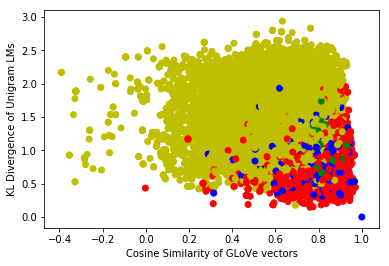

In [15]:
# Plot GLoVe distance vs KL-Divergence on a coloured scatter plot with different colours for each label
colours = np.array(['b', 'g', 'r', 'y'])
plt.scatter(list(x_train[:, 0]), list(x_train[:, 1]), c=colours[y_train])
plt.xlabel('Cosine Similarity of GLoVe vectors')
plt.ylabel('KL Divergence of Unigram LMs')
print([(colours[i], le.classes_[i]) for i in range(len(le.classes_))])
plt.show()

In [16]:
# TODO implement linear/logistic regression classifier using these features. Optimise params on validation set
clf = GradientBoostingClassifier(n_estimators=200, random_state=14128, verbose=True)  # TODO temporary classifier
clf.fit(x_train, y_train)

      Iter       Train Loss   Remaining Time 
         1       30970.9259           22.10s
         2       26682.6466           19.41s
         3       23157.0273           18.39s
         4       20232.1912           17.74s
         5       17790.0845           17.12s
         6       15743.9991           16.91s
         7       14016.2216           16.65s
         8       12553.0982           16.44s
         9       11305.2716           16.26s
        10       10249.8714           16.11s
        20        5380.8799           14.99s
        30        4275.9670           13.83s
        40        3964.5386           12.70s
        50        3813.6782           11.82s
        60        3709.0191           10.89s
        70        3620.4136           10.03s
        80        3543.6376            9.19s
        90        3485.6605            8.37s
       100        3437.6523            7.57s
       200        3008.7798            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=14128, subsample=1.0,
              verbose=True, warm_start=False)

In [17]:
# Initialise x and y for validation dataset
x_val = np.array([to_feature_array(doc) for doc in tqdm(val_all)])
print(x_val[:5])

y_val = le.transform(list(val_all[:, 2]))
print(y_val[:5])

100%|██████████████████████████████████████████████████████████████████████████████| 4998/4998 [00:57<00:00, 87.10it/s]


[[0.51601687 1.65924808]
 [0.51601687 1.65924808]
 [0.51601687 1.65924808]
 [0.51601687 1.65924808]
 [0.72657687 1.99851117]]
[3 3 3 3 3]


In [19]:
# Predict y for validation set
y_pred = clf.predict(x_val)
print(y_pred[:5])

[3 3 3 3 3]


In [31]:
# Compare y_pred and y for validation set
actual = le.inverse_transform(y_val)
predicted = le.inverse_transform(y_pred)
confusion_matrix(actual, predicted)
# TODO save to .csv (see data/scorer.py)
# score, cm = score_submission(actual, predicted)
# print(score)
# print_confusion_matrix(cm)

C:\Users\user\Anaconda3\envs\fnc\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\user\Anaconda3\envs\fnc\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[   0,    0,   13,    9],
       [   0,    0,    1,    0],
       [   2,    0,   87,   78],
       [   1,    1,   39, 4767]], dtype=int64)

In [ ]:
# TODO analyse importance of each feature

In [ ]:
# Unused code, could be useful again later

# Generate language model representations of headlines and bodies (bag of words / no. of words in doc for a 1-gram LM)
# Sparse matrix division, because regular '/' would convert it to dense which will run out of memory
# Equivalent to lang_models = bag_of_words/bag_of_words.sum(axis=1)[:, 0] 
# (Credit to https://stackoverflow.com/questions/42225269/scipy-sparse-matrix-division)
b = sparse.bsr_matrix(bag_of_words)
c = sparse.diags(1/b.sum(axis=1).A.ravel())
lang_models = c @ b

print(lang_models.sum(axis=1)) # every element should be 1
print(lang_models.shape, bag_of_words.shape)